In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
def graph_from_txt(nodes_file_name = None, edges_file_name = None, sep = '\t', nid = None, eidfrom = None, eidto = None):
	"""Summary
	
	Args:
		nodes_file_name (str, optional): the file in which to find node ids and attributes
		edges_file_name (str, optional): the file in which to find edge ids and attributes
		sep (str, optional): the separator character used in the node and edge files
		nid (str, optional): the hashable attribute used to identify nodes
		eidfrom (str, optional): the hashable attribute used to identify sources of edges (must match nid)
		eidto (str, optional): the hashable attribute used to identify targets of edges (must match nid)
	
	Returns:
		a networkx.DiGraph() object
	"""
	nodes = pd.read_table(nodes_file_name, sep = sep, index_col=False)
	for col in nodes:
		nodes[col] = pd.to_numeric(nodes[col], errors = 'ignore')
	
	N = nx.DiGraph()
	for n in range(len(nodes)):
		attr = {nid: nodes[nid][n]}
		attr2 = {col: nodes[col][n] for col in list(nodes) if col != nid}
		attr.update(attr2)
		
		N.add_node(n = nodes[nid][n], attr_dict = attr)

	if edges_file_name is not None: 
		edges = pd.read_table(edges_file_name, sep = sep, index_col=False)
		for col in edges:
			edges[col] = pd.to_numeric(edges[col], errors = 'ignore')

		for e in range(len(edges)):
			attr = {eidfrom : edges[eidfrom][e], eidto : edges[eidto][e]}
			attr2 = {col: edges[col][e] for col in list(edges)}
			attr.update(attr2)
			N.add_edge(edges[eidfrom][e], edges[eidto][e], attr)

	return N

# DATA

[(24.6683, 24.6983), (46.7017, 46.731700000000004)]

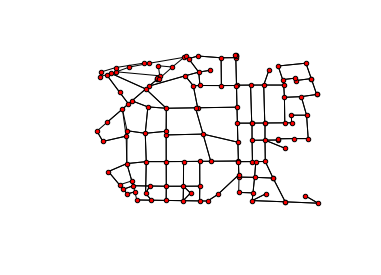

In [3]:
# Read in the network
N = graph_from_txt('1_data/street/street_nodes.txt', 
                   '1_data/street/street_edges.txt', 
                   sep = ' ',
                   nid = 'id',
                   eidfrom = 'source',
                   eidto = 'target')
# Define geography
center_point = (46.7167, 24.6333)
l = .01

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

# Prune down the graph and draw
keep_points = [n for n in N.node 
                 if xlim[0] < N.node[n]['st_x'] < xlim[1]
                 and ylim [0] < N.node[n]['st_y'] < ylim[1]]
G = N.subgraph(keep_points)

G.remove_nodes_from([n for n in G if G.degree()[n] == 0])
G = nx.convert_node_labels_to_integers(G)

xlim = (xlim[0] - .005, xlim[1] + .005)
ylim = (ylim[0] - .005, ylim[1] + .005)

G.pos = {n : (G.node[n]['st_x'], G.node[n]['st_y']) for n in G.node}
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(G, G.pos, node_size=20, ax = ax, arrows = False)
ax.set(xlim = xlim, ylim = ylim)

# Random Data

In [4]:
nodes = G.nodes()
N = len(nodes)

# UPDATE RULE

In [378]:
tau = 0.000005
w = 20
r = 5
t = 5

In [379]:
def update(flow, wage, rent, travel): # Euler method
    
    df      = np.square(flow) * (w * wage - r * rent - t * travel)
    df      = df - df.mean()
    flow   += tau * df # centered, not sure if this is really the best way to conserve flow
    wage    = np.array([sum([flow.sum(axis = 0)[i] for i in nx.ego_graph(G, j).nodes()]) for j in nodes]) 
    rent    = np.array([sum([flow.sum(axis = 1)[i] for i in nx.ego_graph(G, j).nodes()]) for j in nodes]) 
    rent    = rent.reshape(N,1)
    
    rent   *= RENT / rent.sum()
    wage   *= WAGE / wage.sum()
    
    travel  = (1 + .15 * np.square(flow / 1)) * dists

    return flow, travel, wage, rent

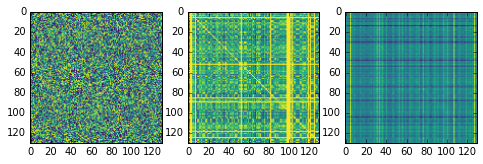

In [380]:
shortest_paths = nx.shortest_path_length(G, weight = 'cost_time_m')

dists = np.zeros((N,N))
for n in shortest_paths:
    for m in shortest_paths[n]:
        dists[n][m] = shortest_paths[n][m]
        
wage = np.random.exponential(1,N) * 3
rent = np.random.exponential(1,N) * 3
rent = rent.reshape(N, 1)

flow = np.random.rand(N,N) + 1
travel = 1 * np.square(flow) * dists

FLOW = flow.sum()
WAGE = wage.sum()
RENT = rent.sum()

fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot(131)
ax.imshow(flow, cmap = 'viridis')
ax = fig.add_subplot(132)
ax.imshow(dists, cmap = 'viridis_r')
ax = fig.add_subplot(133)
ax.imshow(wage - rent - dists, cmap = 'viridis')

In [381]:
for i in range(500):
    flow, travel, wage, rent = update(flow, wage, rent, travel)
    flow = np.round(flow, 4)
    travel = np.round(travel, 4)
    wage = np.round(wage, 4)
    rent = np.round(rent, 4)
    if i % 50 == 0:
        print flow.max(), travel.max(), wage.max(), rent.max()

2.0044 9.8973 5.8861 4.6419
2.0867 9.8247 5.8967 4.6316
2.1835 9.7528 5.91 4.6212
2.292 9.6816 5.9524 4.6108
2.4136 9.6112 5.9986 4.6006
2.5512 9.6812 6.0489 4.5901
2.7081 9.7736 6.1043 4.5796
2.8884 9.8671 6.1652 4.569
3.0976 9.9616 6.2324 4.5584
3.3507 10.0573 6.3073 4.548


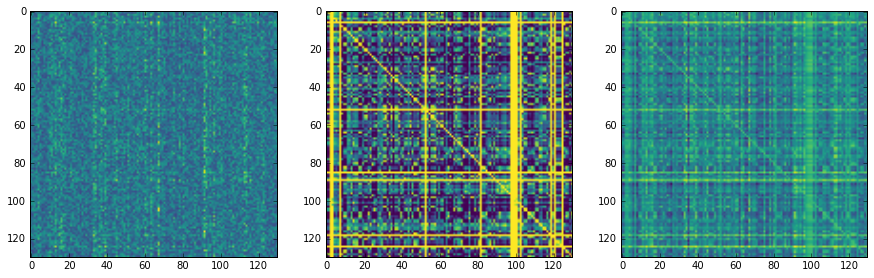

In [382]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(131)
ax.imshow(flow, cmap = 'viridis', vmin = 0, vmax = flow.max())
ax = fig.add_subplot(132)
ax.imshow(dists, cmap = 'viridis_r', vmin = 0, vmax = flow.max())
ax = fig.add_subplot(133)
ax.imshow(wage - rent - travel, cmap = 'viridis')

# MODELING PARAMS

# MODEL

[(0, 5.0)]

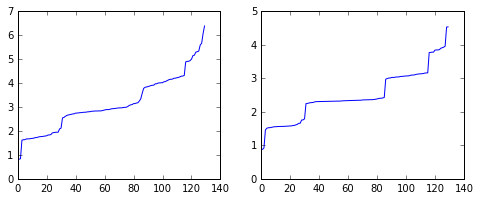

In [383]:
fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(121)
sorted_wage = wage.copy()
sorted_wage.sort()
ax.plot(sorted_wage)
ax.set(ylim = (0, None))

ax = fig.add_subplot(122)
sorted_rent = rent.copy()
sorted_rent = sorted_rent.reshape(1,N)
sorted_rent.sort()
ax.plot(sorted_rent.tolist()[0])
ax.set(ylim = (0, None))

[(0, 240.0)]

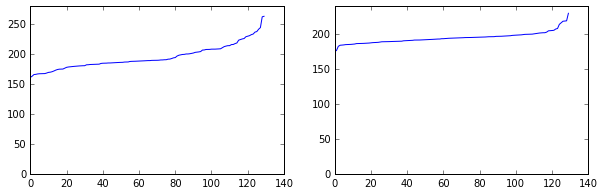

In [384]:
fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(121)
ax.plot(np.sort(flow.sum(axis = 0)))
ax.set(ylim = (0, None))


ax = fig.add_subplot(122)
ax.plot(np.sort(flow.sum(axis = 1)))
ax.set(ylim = (0, None))

[(0, 240.0), (0, 280.0)]

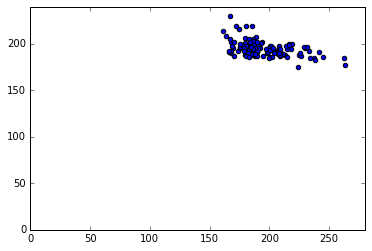

In [390]:
plt.scatter(flow.sum(axis = 0), flow.sum(axis = 1))
plt.gca().set(xlim = (0,None), ylim = (0, None))

[(0, 7.0), (0, 5.0)]

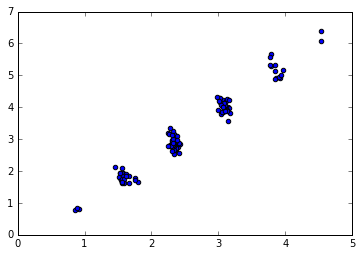

In [391]:
plt.scatter(rent, wage)
plt.gca().set(xlim = (0, None), ylim = (0, None))

[(24.6683, 24.6983),
 (46.7017, 46.731700000000004),

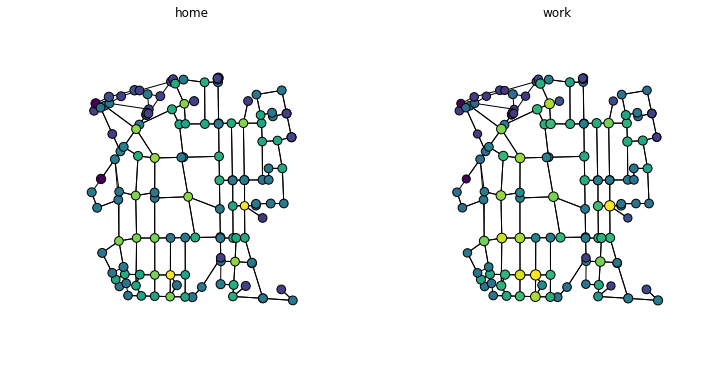

In [400]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121)
nx.draw(G, G.pos, 
        node_size = .4 * flow.sum(axis = 1), 
        node_color = rent,
#         node_color = .4 * flow.sum(axis = 1),
        ax = ax, 
        arrows = False,
        cmap = 'viridis')
ax.set(xlim = xlim, ylim = ylim, title = 'home')
ax = fig.add_subplot(122)
nx.draw(G, G.pos, 
        node_size = .4 * flow.sum(axis = 0), 
        node_color = wage,
#         node_color = .4 * flow.sum(axis = 0),
        ax = ax, 
        arrows = False,
        cmap = 'viridis',
        vmax = 6)
ax.set(xlim = xlim, ylim = ylim, title = 'work')

[(0, 7.0), (0, 280.0)]

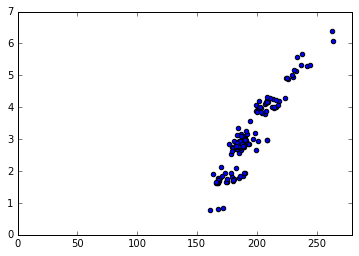

In [393]:
plt.scatter(flow.sum(axis = 0), wage)
plt.gca().set(xlim = (0, None), ylim = (0, None))

[(0, 5.0), (0, 240.0)]

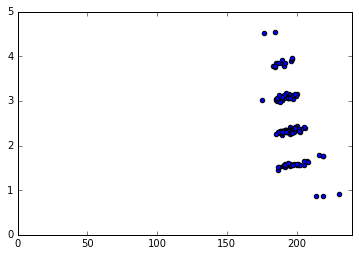

In [394]:
plt.scatter(flow.sum(axis = 1), rent)
plt.gca().set(xlim = (0, None), ylim = (0, None))